In [1]:
from mainv3 import SystemDesign

- use weighting as a variable
- encorporate for javh_groups

### Plan of system creation ofr ja_groups
```python
system_columns = ['solvent_1','solvent_2','temperature','compound_id']
extra_fitted_points=1-4

```

In [ ]:
system_5 = {
    'system_columns': ['solvent_1', 'solvent_2', 'temperature'],
    'extra_fitted_points': 1,
    'name': 'system_sst_1',
}

system_6 = {
    'system_columns': ['solvent_1', 'solvent_2', 'temperature'],
    'extra_fitted_points': 2,
    'name': 'system_sst_2',
}

system_7 = {
    'system_columns': ['solvent_1', 'solvent_2'],
    'extra_fitted_points': 1,
    'name': 'system_ss_1',
}

system_8 = {
    'system_columns': ['solvent_1', 'solvent_2'],
    'extra_fitted_points': 2,
    'name': 'system_ss_2',
}

system_9 = {
    'system_columns': ['solvent_1'],
    'extra_fitted_points': 1,
    'name': 'system_s_1',
}

system_10 = {
    'system_columns': ['solvent_1'],
    'extra_fitted_points': 2,
    'name': 'system_s_2',
}

system_11 = {
    'system_columns': [],
    'extra_fitted_points': 1,
    'name': 'system_1',
}

system_12 = {
    'system_columns': [],
    'extra_fitted_points': 2,
    'name': 'system_1',
}

system_13 = {
    'system_columns': [],
    'extra_fitted_points': 3,
    'name': 'system_3',
}

system_14 = {
    'system_columns': ['solvent_1', 'solvent_2', 'temperature'],
    'extra_fitted_points': 0,
    'name': 'system_sst_0',
}

system_15 = {
    'system_columns': ['solvent_1', 'solvent_2'],
    'extra_fitted_points': 0,
    'name': 'system_ss_0',
}

system_16 = {
    'system_columns': ['solvent_1'],
    'extra_fitted_points': 0,
    'name': 'system_s_0',
}

system_17 = {
    'system_columns': [],
    'extra_fitted_points': 0,
    'name': 'system_0',
}

systems = [
    system_5,
    system_6,
    system_7,
    system_8,
    system_9,
    system_10,
    system_11,
    system_12,
    system_14,
    system_15,
    system_16,
    system_17,

]

from vae_model import VAEWithFeatureSelection
from neural_network_model import NeuralNetworkWithFeatureSelection
from xgb_model import XGBoostWithFeatureSelection
from itertools import product


models = [
    {
        'name': 'vae',
        'model_class' : VAEWithFeatureSelection
    },
    {
        'name': 'nn',
        'model_class' : NeuralNetworkWithFeatureSelection
    },
    {
        'name': 'xgb',
        'model_class' : XGBoostWithFeatureSelection
    }
]

n_features = [
    {
        'name': '10_features',
        'n_features': 10
    },
    {
        'name': '50_features',
        'n_features': 50
    },
    {
        'name': '500_features',
        'n_features': 500
    }
]

systemPermutations = [
    {
        'system': system,
        'model': model,
        'n_features': n_feature
    }
    for system, model, n_feature in product(systems, models, n_features)
]

len(systemPermutations)

36

In [ ]:
import time
import os

def train_and_save_system(system_permutation, raw_data_path='curve_fit_results_x_is_7.csv', base_save_path="../../output/models/"):
    """
    Train and save a model system based on a system permutation configuration.
    
    Args:
        system_permutation (dict): Dictionary containing system, model, and n_features configurations
        raw_data_path (str): Path to the raw data file
        base_save_path (str): Base directory for saving models
    """
    # Extract configuration
    system_config = system_permutation['system']
    model_config = system_permutation['model']
    n_features_config = system_permutation['n_features']
    
    print(f"Training {model_config['name']} model with {system_config['name']} using {n_features_config['name']}")
    
    # Create system
    system = SystemDesign(
        system_columns=system_config['system_columns'],
        raw_data_path=raw_data_path,
        extra_fitted_points=system_config['extra_fitted_points'],
        target_columns=['J0', 'J1', 'J2']
    )
    
    # Common parameters for all models
    common_params = {
        'feature_selection_method': 'random_forest',
        'n_features': n_features_config['n_features'],
        'keep_prefixes': ['solvent_1_pure', 'solvent_2_pure', 'system', 'solubility_', 'temperature'],
        'verbose': 1,
        'optimize_hyperparams': True,
        'n_calls': 100
    }
    
    # Model-specific parameters
    if model_config['name'] == 'vae':
        model_params = {
            'epochs': 1000,
            'batch_size': 32,
            'latent_dim': 16,
            'kl_weight': 0.001
        }
    elif model_config['name'] == 'nn':
        model_params = {
            'epochs': 1000,
            'batch_size': 32
        }
    elif model_config['name'] == 'xgb':
        model_params = {
            'n_estimators': 200,
            'max_depth': 6
        }
    
    # Train the model
    system.train_model(
        model_class=model_config['model_class'],
        **common_params,
        **model_params
    )
    
    # Evaluate the model
    system.evaluate_model()
    
    # Construct save path
    model_name = f"{model_config['name']}_{system_config['name']}_{n_features_config['name']}.pkl"
    save_path = base_save_path + model_name
    
    # Save the model
    system.save(save_path)
    
    return system, model_name

def run_all_systems(system_permutations, start_idx=0, max_systems=None, raw_data_path='curve_fit_results_x_is_7.csv', 
                   base_save_path="../../output/models/"):
    """
    Run and save all systems in the provided list of system permutations.
    
    Args:
        system_permutations (list): List of system permutation configurations
        start_idx (int): Index to start from (for resuming interrupted runs)
        max_systems (int): Maximum number of systems to train (None = all)
        raw_data_path (str): Path to the raw data file
        base_save_path (str): Base directory for saving models
    """
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(base_save_path), exist_ok=True)
    
    end_idx = len(system_permutations) if max_systems is None else min(start_idx + max_systems, len(system_permutations))
    total_time = 0
    trained_models = []
    
    for i, system_permutation in enumerate(system_permutations[start_idx:end_idx], start=start_idx):
        print(f"\nTraining system {i+1}/{end_idx} ({i+1}/{len(system_permutations)} total)")
        print("-" * 50)
        
        start_time = time.time()
        try:
            system, model_name = train_and_save_system(system_permutation, raw_data_path, base_save_path)
            elapsed = time.time() - start_time
            total_time += elapsed
            trained_models.append(model_name)
            
            avg_time = total_time / (i - start_idx + 1)
            remaining = (end_idx - i - 1) * avg_time
            
            print(f"Training completed in {elapsed:.2f} seconds")
            print(f"Estimated time remaining: {remaining/60:.2f} minutes")
        except Exception as e:
            print(f"Error training system: {str(e)}")
        
        print("-" * 50)
    
    return trained_models


Training system 1/36 (1/36 total)
--------------------------------------------------
Training vae model with system_sst_1 using 10_features
Selecting top 10 features using random_forest method...
Selected 389 features (379 from prefixes, 10 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.9652
Function value obtained: 0.6929
Current minimum: 0.6929
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 19.7863
Function value obtained: 0.1604
Current minimum: 0.1604
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 13.7454
Function value obtained: 0.1699
Current minimum: 0.1604
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random p

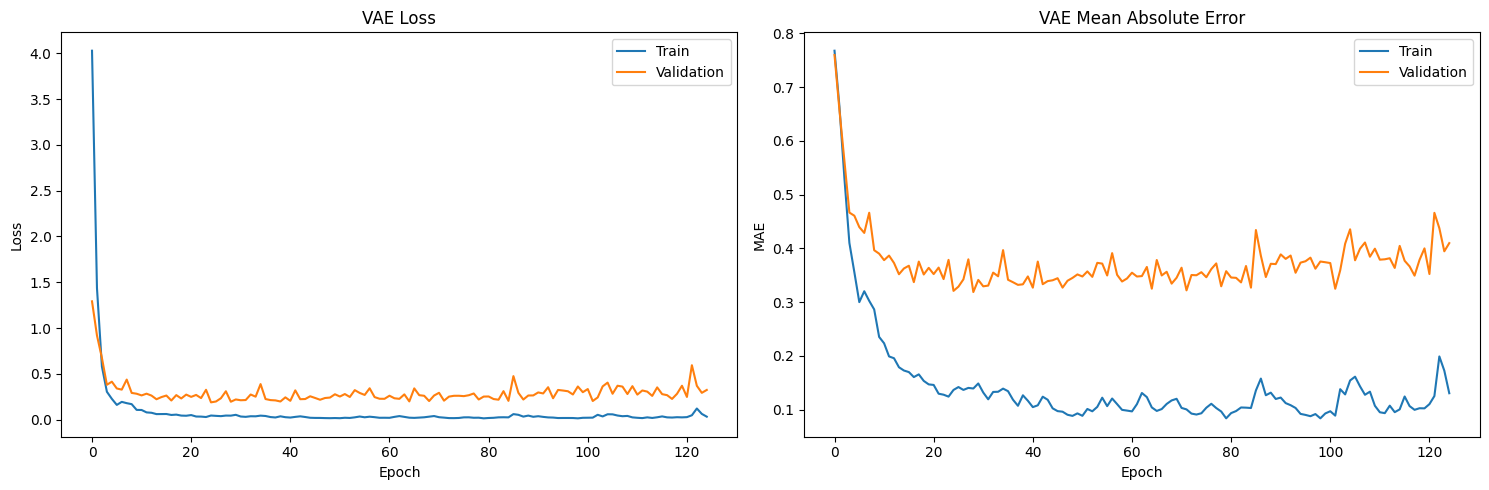

System saved to ../../output/models/vae_system_sst_1_10_features.pkl
Training completed in 140.87 seconds
Estimated time remaining: 82.18 minutes
--------------------------------------------------

Training system 2/36 (2/36 total)
--------------------------------------------------
Training vae model with system_sst_1 using 50_features
Selecting top 50 features using random_forest method...
Selected 429 features (379 from prefixes, 50 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.0880
Function value obtained: 0.6738
Current minimum: 0.6738
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 20.0821
Function value obtained: 0.1350
Current minimum: 0.1350
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at rando

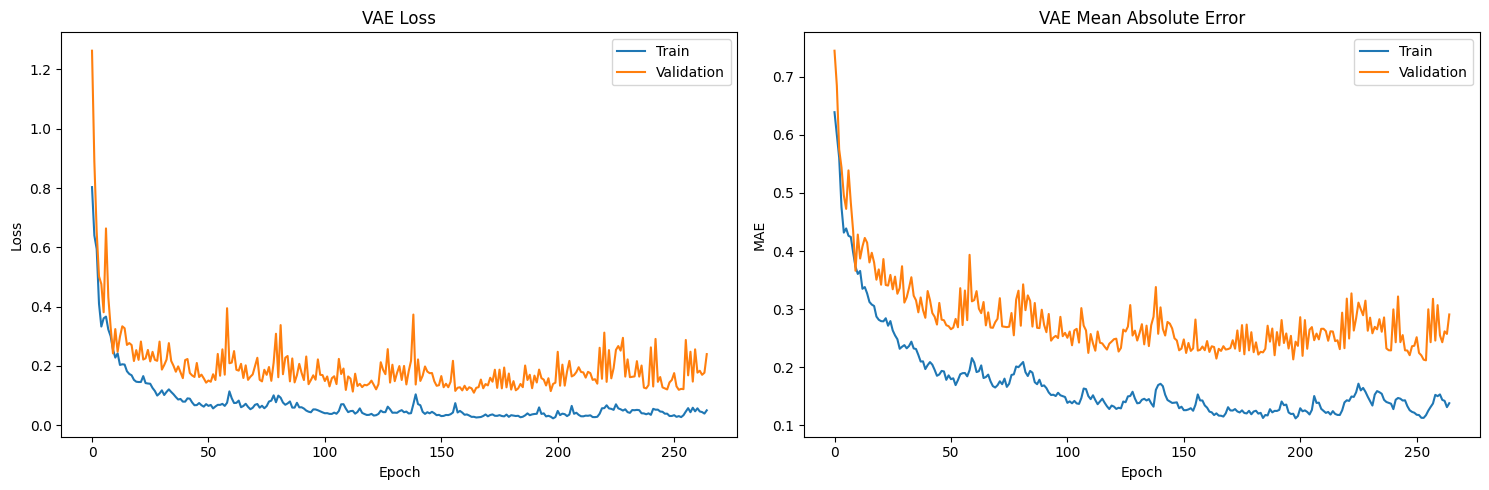

System saved to ../../output/models/vae_system_sst_1_50_features.pkl
Training completed in 209.25 seconds
Estimated time remaining: 99.20 minutes
--------------------------------------------------

Training system 3/36 (3/36 total)
--------------------------------------------------
Training vae model with system_sst_1 using 500_features
Selecting top 500 features using random_forest method...
Selected 734 features (379 from prefixes, 355 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.2358
Function value obtained: nan
Current minimum: nan
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 9.8715
Function value obtained: nan
Current minimum: nan
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
T

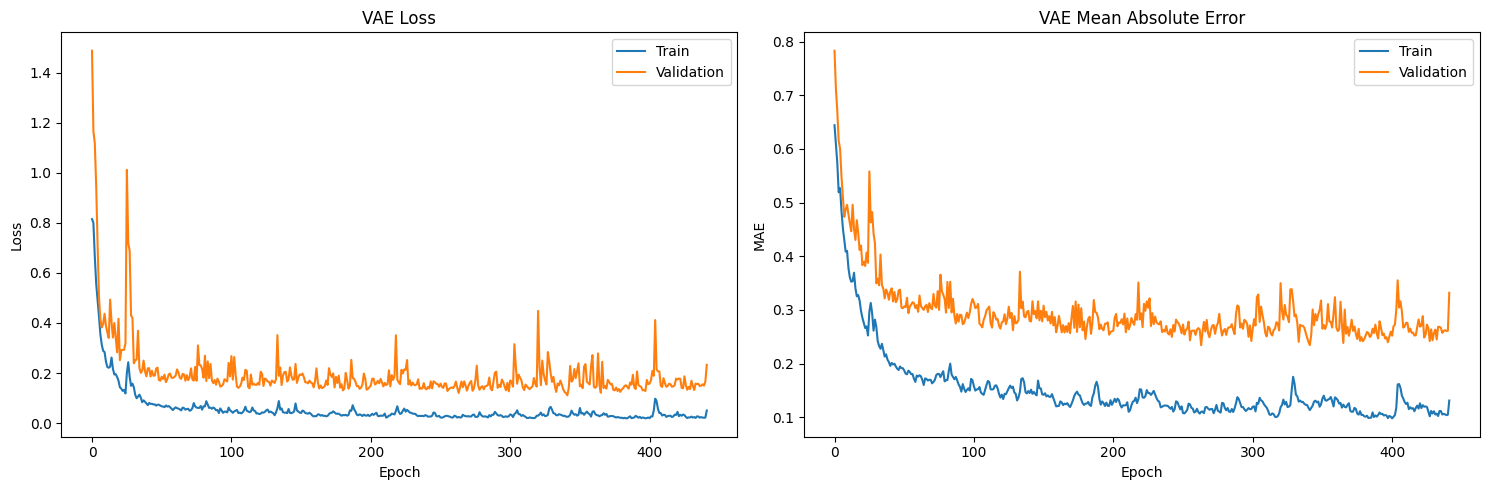

System saved to ../../output/models/vae_system_sst_2_10_features.pkl
Training completed in 182.95 seconds
Estimated time remaining: 71.08 minutes
--------------------------------------------------

Training system 5/36 (5/36 total)
--------------------------------------------------
Training vae model with system_sst_2 using 50_features
Selecting top 50 features using random_forest method...
Selected 461 features (411 from prefixes, 50 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 15.0936
Function value obtained: 1.4704
Current minimum: 1.4704
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 13.2904
Function value obtained: 0.1762
Current minimum: 0.1762
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at rand

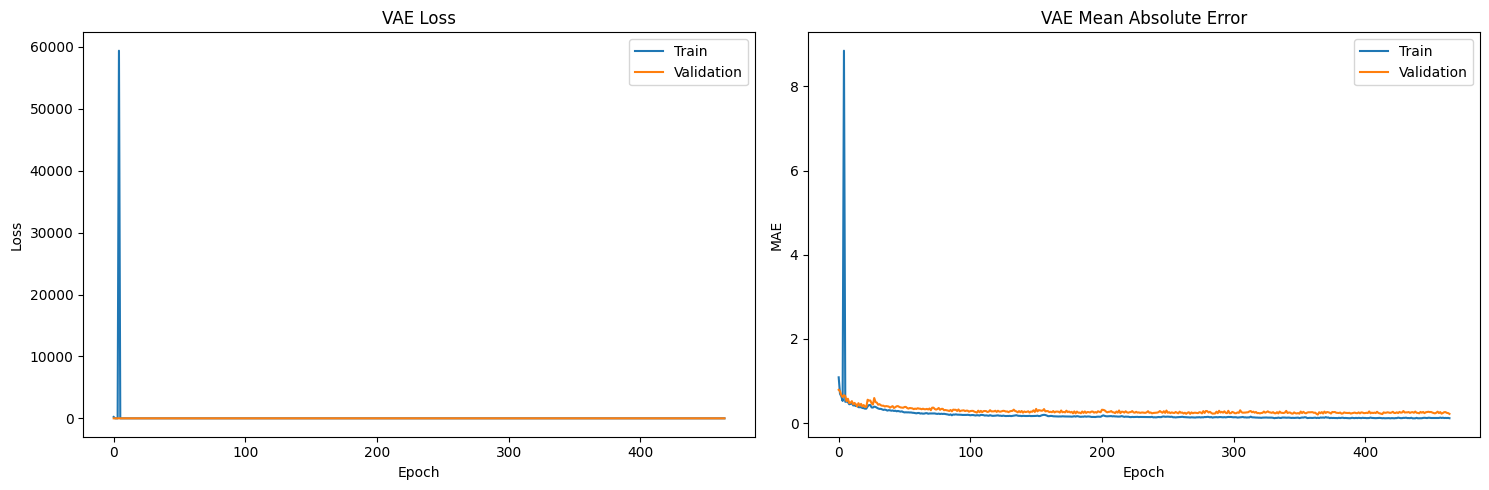

System saved to ../../output/models/vae_system_sst_2_50_features.pkl
Training completed in 180.46 seconds
Estimated time remaining: 73.73 minutes
--------------------------------------------------

Training system 6/36 (6/36 total)
--------------------------------------------------
Training vae model with system_sst_2 using 500_features
Selecting top 500 features using random_forest method...
Selected 766 features (411 from prefixes, 355 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.7983
Function value obtained: nan
Current minimum: nan
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.7839
Function value obtained: nan
Current minimum: nan
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
T

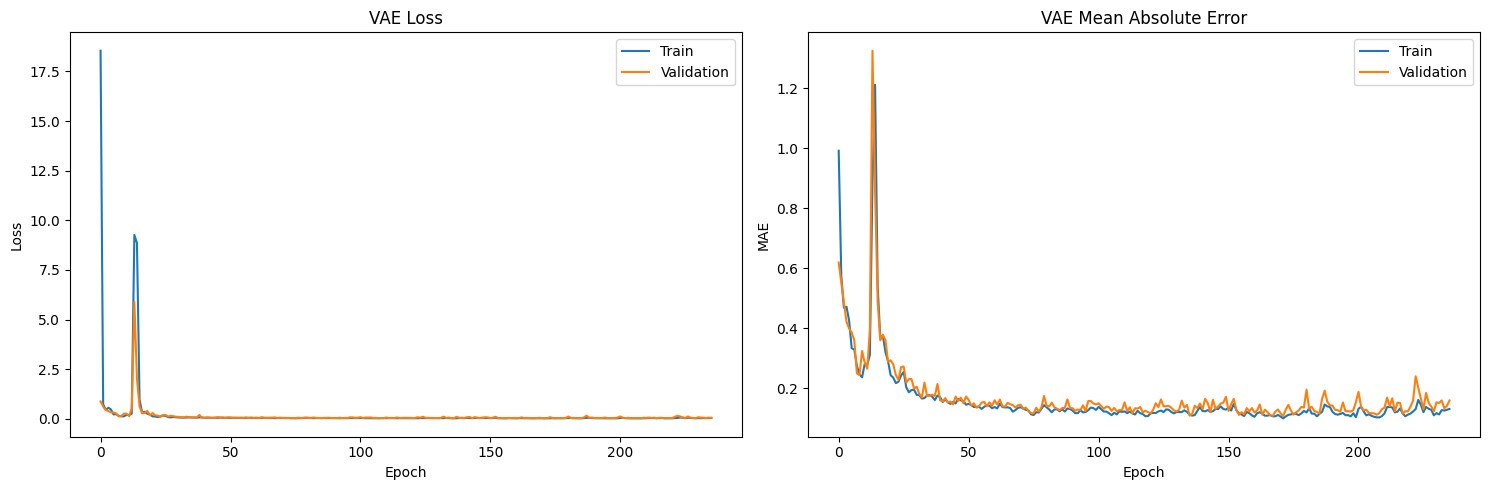

System saved to ../../output/models/vae_system_ss_1_10_features.pkl
Training completed in 160.05 seconds
Estimated time remaining: 60.32 minutes
--------------------------------------------------

Training system 8/36 (8/36 total)
--------------------------------------------------
Training vae model with system_ss_1 using 50_features
Selecting top 50 features using random_forest method...
Selected 128 features (78 from prefixes, 50 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 13.4442
Function value obtained: 0.2997
Current minimum: 0.2997
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 21.5798
Function value obtained: 0.0199
Current minimum: 0.0199
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random 

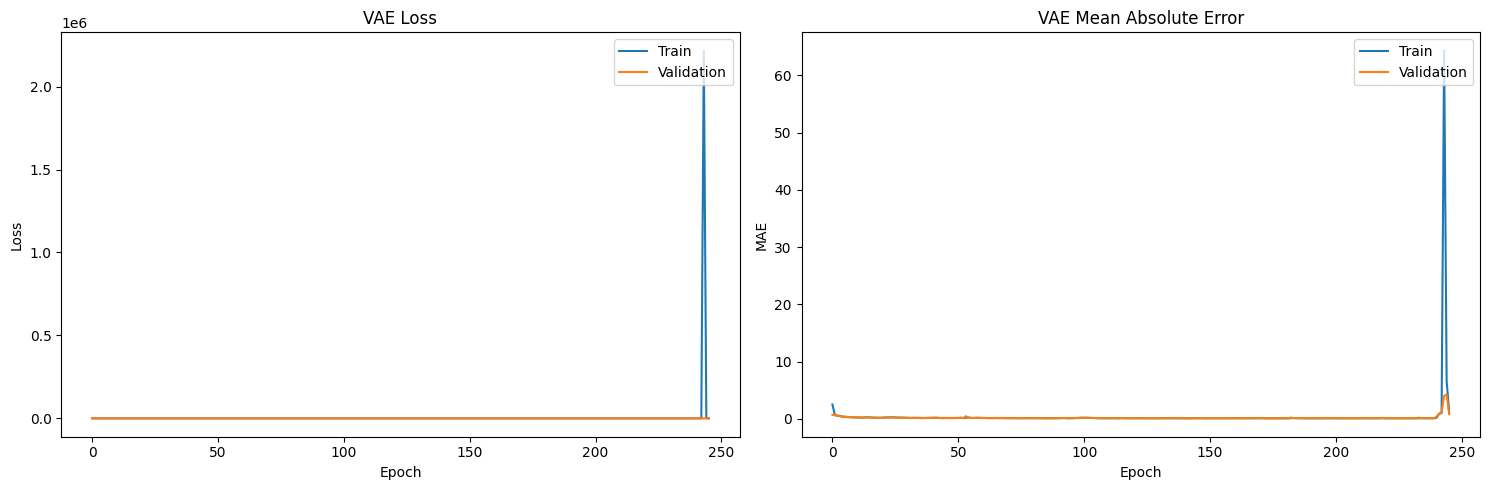

System saved to ../../output/models/vae_system_ss_1_50_features.pkl
Training completed in 161.97 seconds
Estimated time remaining: 60.41 minutes
--------------------------------------------------

Training system 9/36 (9/36 total)
--------------------------------------------------
Training vae model with system_ss_1 using 500_features
Selecting top 500 features using random_forest method...
Selected 433 features (78 from prefixes, 355 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.3521
Function value obtained: nan
Current minimum: nan
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.8342
Function value obtained: nan
Current minimum: nan
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time

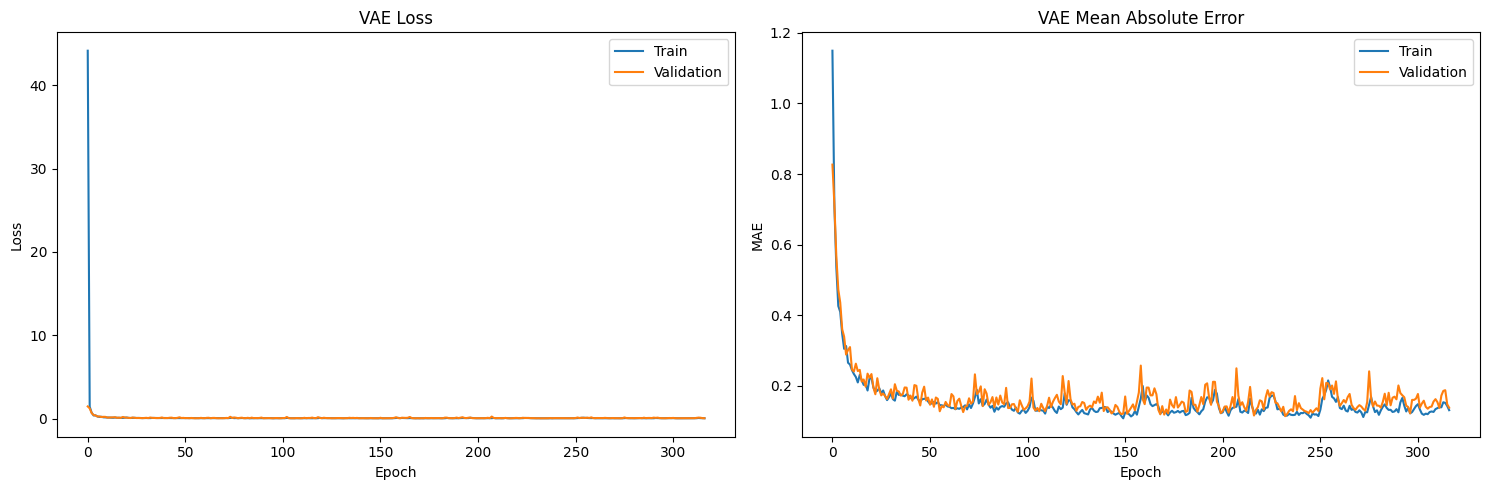

System saved to ../../output/models/vae_system_s_1_10_features.pkl
Training completed in 166.27 seconds
Estimated time remaining: 35.44 minutes
--------------------------------------------------

Training system 14/36 (14/36 total)
--------------------------------------------------
Training vae model with system_s_1 using 50_features
Selecting top 50 features using random_forest method...
Selected 103 features (53 from prefixes, 50 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.3822
Function value obtained: 1.4468
Current minimum: 1.4468
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 9.7240
Function value obtained: 1.4381
Current minimum: 1.4381
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random po

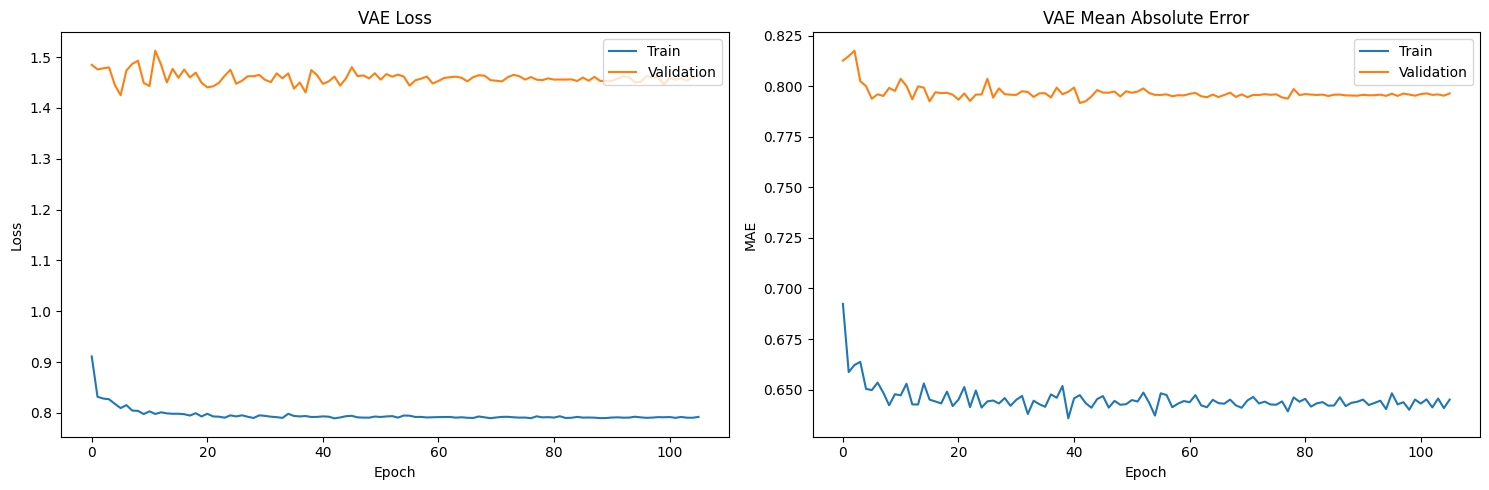

System saved to ../../output/models/vae_system_s_1_50_features.pkl
Training completed in 108.69 seconds
Estimated time remaining: 34.32 minutes
--------------------------------------------------

Training system 15/36 (15/36 total)
--------------------------------------------------
Training vae model with system_s_1 using 500_features
Selecting top 500 features using random_forest method...
Selected 553 features (53 from prefixes, 500 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.4569
Function value obtained: nan
Current minimum: nan
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.2864
Function value obtained: nan
Current minimum: nan
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time

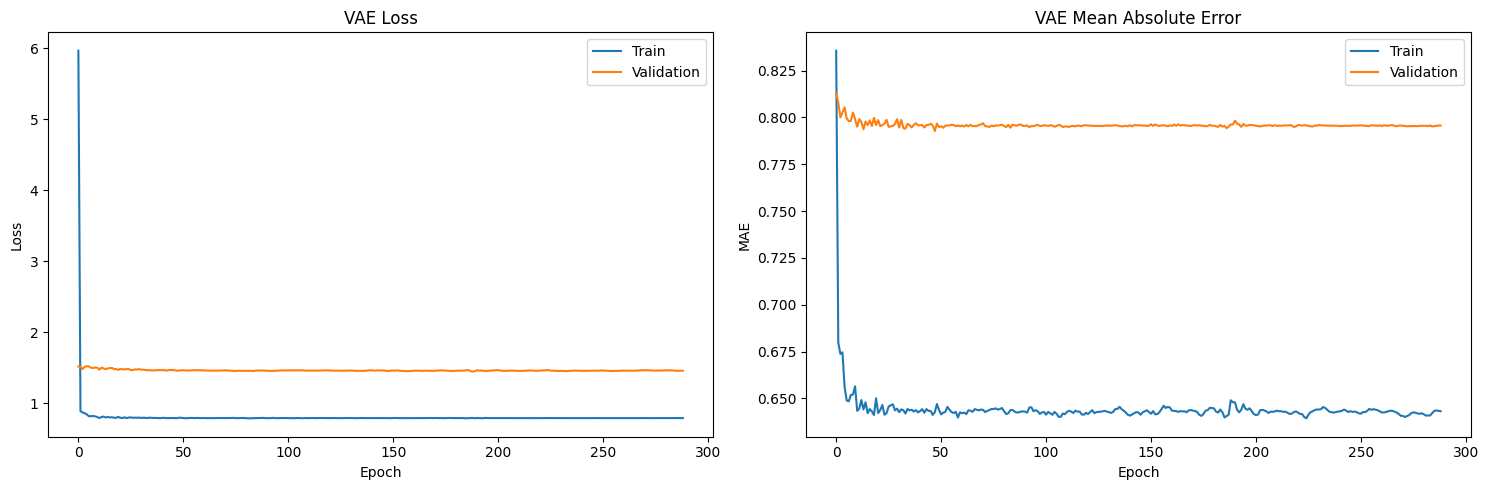

System saved to ../../output/models/vae_system_s_2_50_features.pkl
Training completed in 114.78 seconds
Estimated time remaining: 26.55 minutes
--------------------------------------------------

Training system 18/36 (18/36 total)
--------------------------------------------------
Training vae model with system_s_2 using 500_features
Selecting top 500 features using random_forest method...
Selected 585 features (85 from prefixes, 500 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.4531
Function value obtained: nan
Current minimum: nan
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.1160
Function value obtained: nan
Current minimum: nan
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time

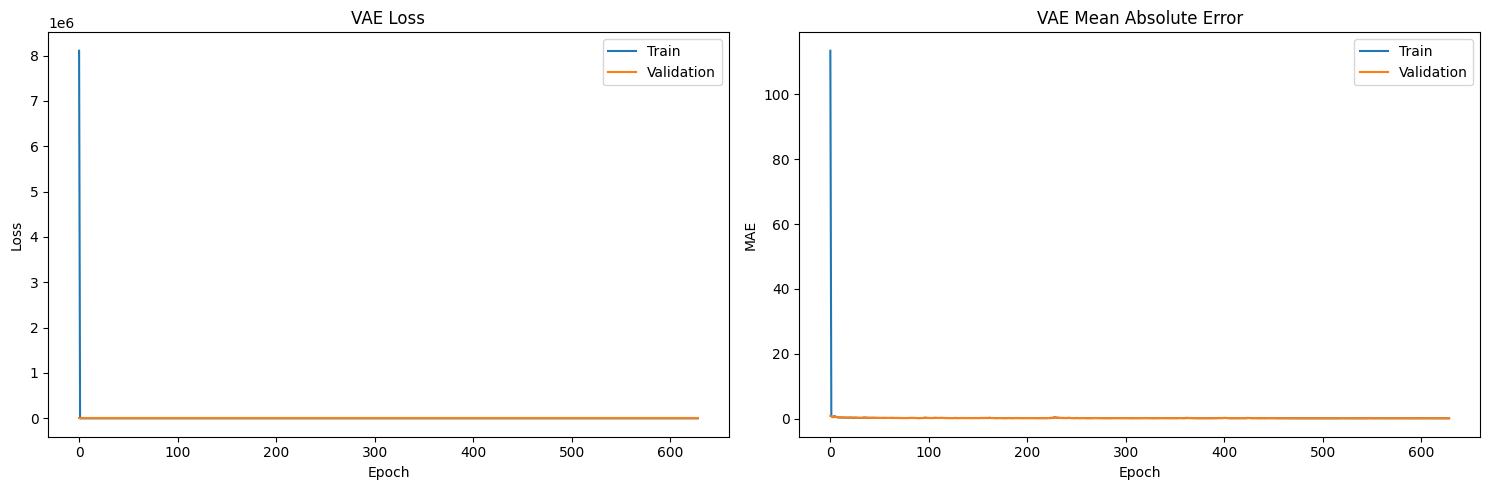

System saved to ../../output/models/vae_system_1_10_features.pkl
Training completed in 225.80 seconds
Estimated time remaining: 24.62 minutes
--------------------------------------------------

Training system 20/36 (20/36 total)
--------------------------------------------------
Training vae model with system_1 using 50_features
Selecting top 50 features using random_forest method...
Selected 86 features (36 from prefixes, 50 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.6110
Function value obtained: 1.4420
Current minimum: 1.4420
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 12.3329
Function value obtained: 1.4479
Current minimum: 1.4420
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.

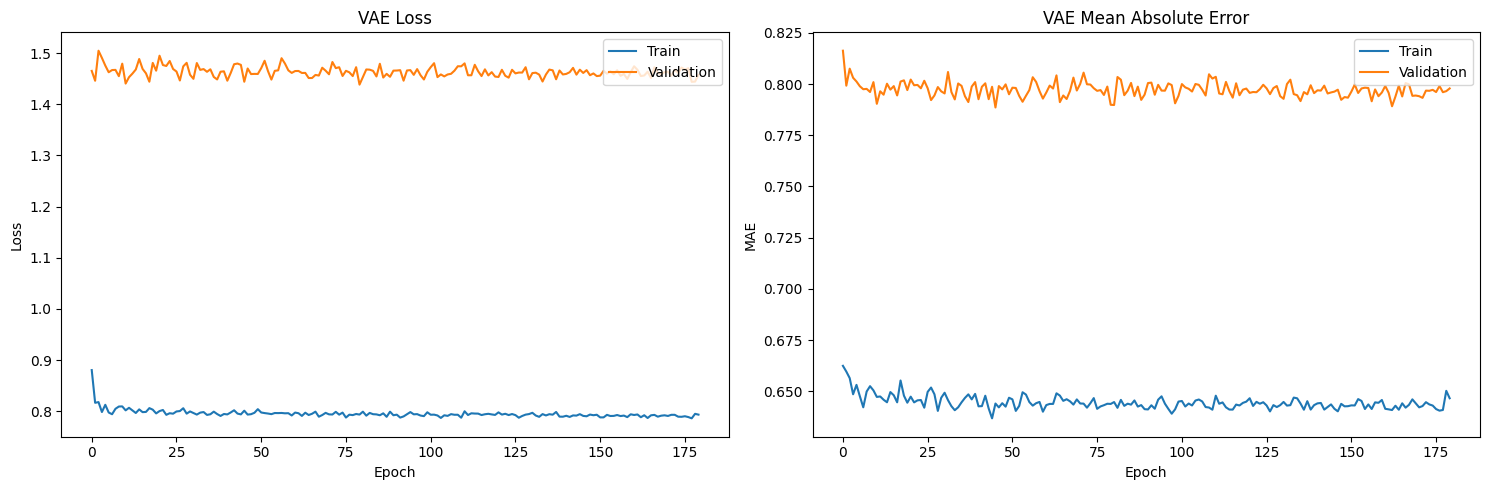

System saved to ../../output/models/vae_system_1_50_features.pkl
Training completed in 105.80 seconds
Estimated time remaining: 23.43 minutes
--------------------------------------------------

Training system 21/36 (21/36 total)
--------------------------------------------------
Training vae model with system_1 using 500_features
Selecting top 500 features using random_forest method...
Selected 536 features (36 from prefixes, 500 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.6859
Function value obtained: nan
Current minimum: nan
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.5066
Function value obtained: 1.6034
Current minimum: nan
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time 

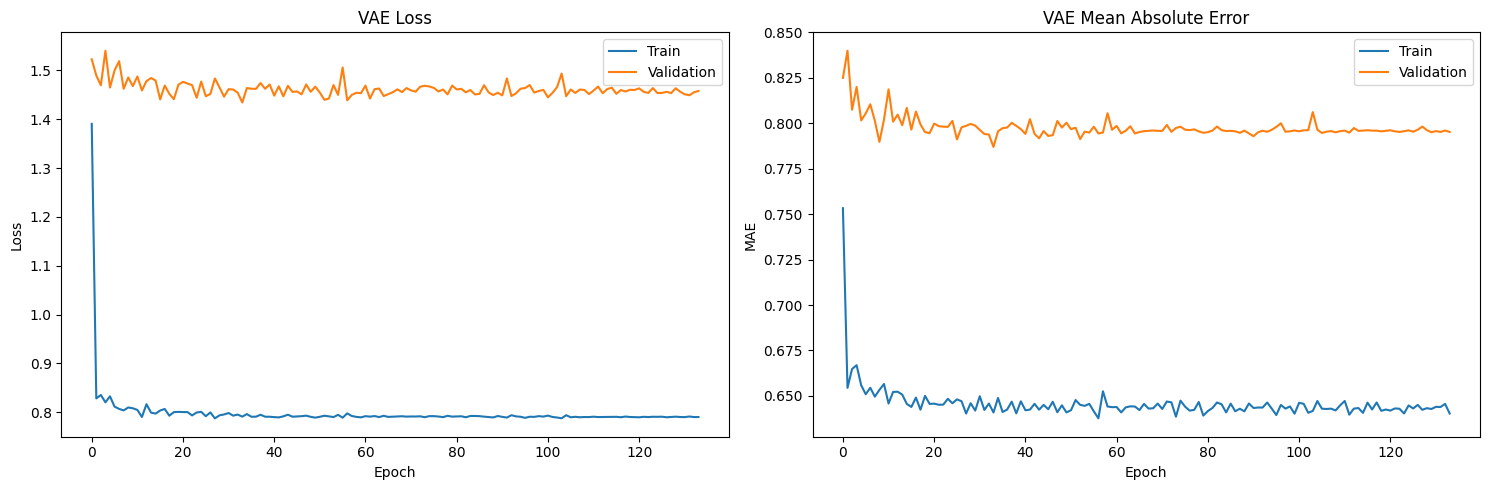

System saved to ../../output/models/vae_system_1_50_features.pkl
Training completed in 96.30 seconds
Estimated time remaining: 17.46 minutes
--------------------------------------------------

Training system 24/36 (24/36 total)
--------------------------------------------------
Training vae model with system_1 using 500_features
Selecting top 500 features using random_forest method...
Selected 568 features (68 from prefixes, 500 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.4270
Function value obtained: nan
Current minimum: nan
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.8652
Function value obtained: nan
Current minimum: nan
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time take

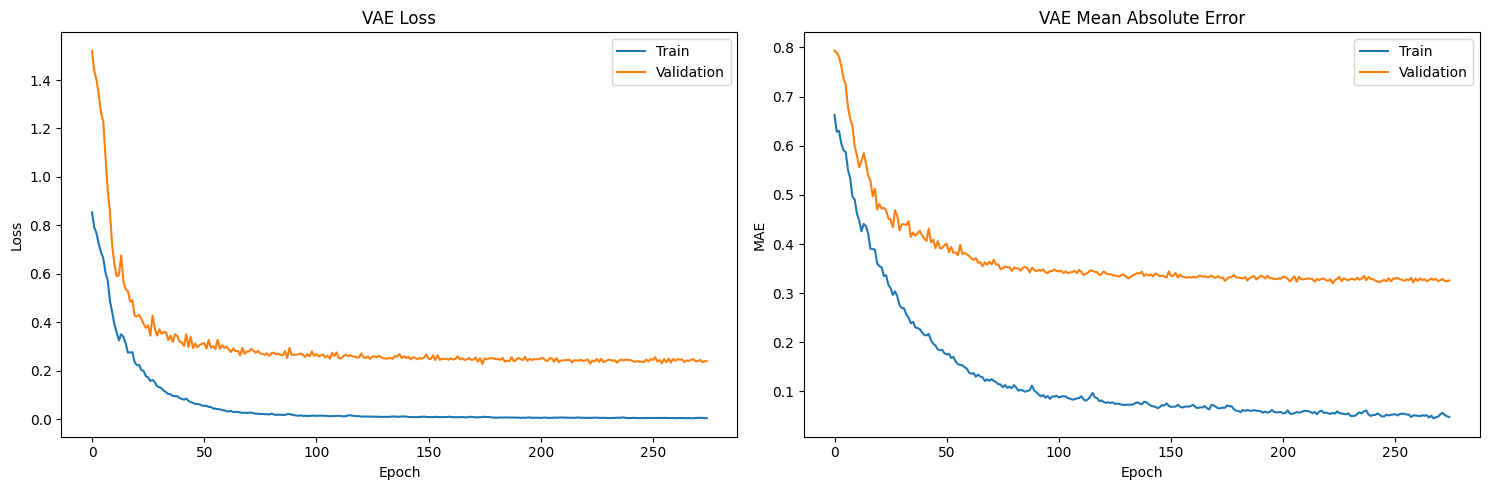

System saved to ../../output/models/vae_system_sst_0_10_features.pkl
Training completed in 162.84 seconds
Estimated time remaining: 14.78 minutes
--------------------------------------------------

Training system 26/36 (26/36 total)
--------------------------------------------------
Training vae model with system_sst_0 using 50_features
Selecting top 50 features using random_forest method...
Selected 397 features (347 from prefixes, 50 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 13.4931
Function value obtained: 0.2258
Current minimum: 0.2258
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 12.8970
Function value obtained: 0.2232
Current minimum: 0.2232
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at ra

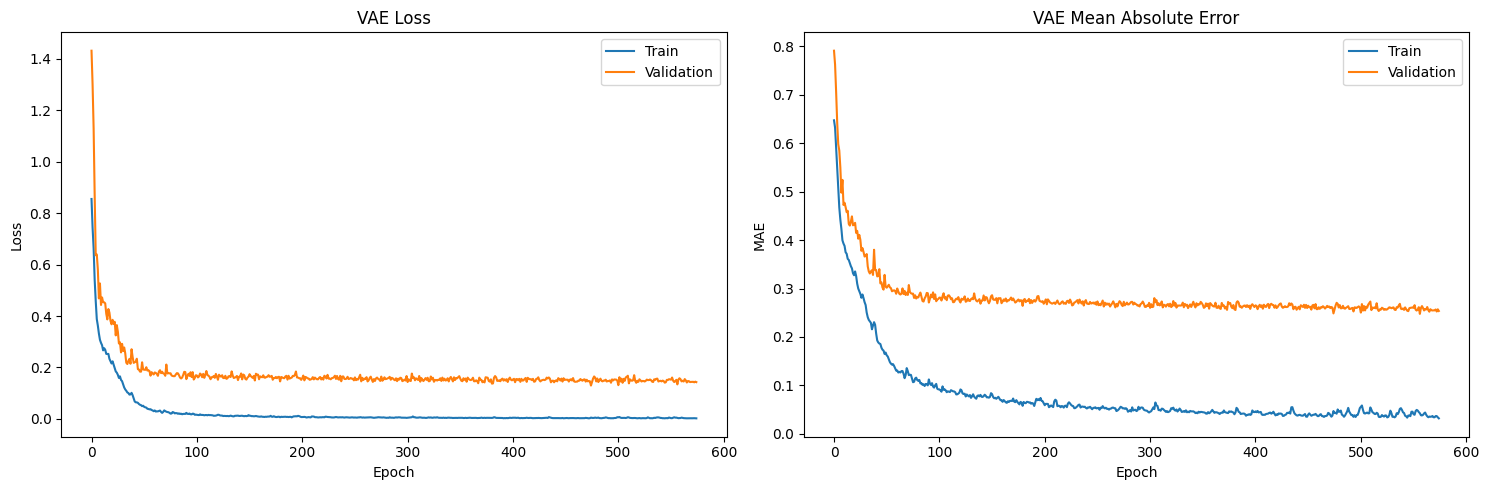

System saved to ../../output/models/vae_system_sst_0_50_features.pkl
Training completed in 212.91 seconds
Estimated time remaining: 14.29 minutes
--------------------------------------------------

Training system 27/36 (27/36 total)
--------------------------------------------------
Training vae model with system_sst_0 using 500_features
Selecting top 500 features using random_forest method...
Selected 702 features (347 from prefixes, 355 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.3481
Function value obtained: nan
Current minimum: nan
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.9004
Function value obtained: nan
Current minimum: nan
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.

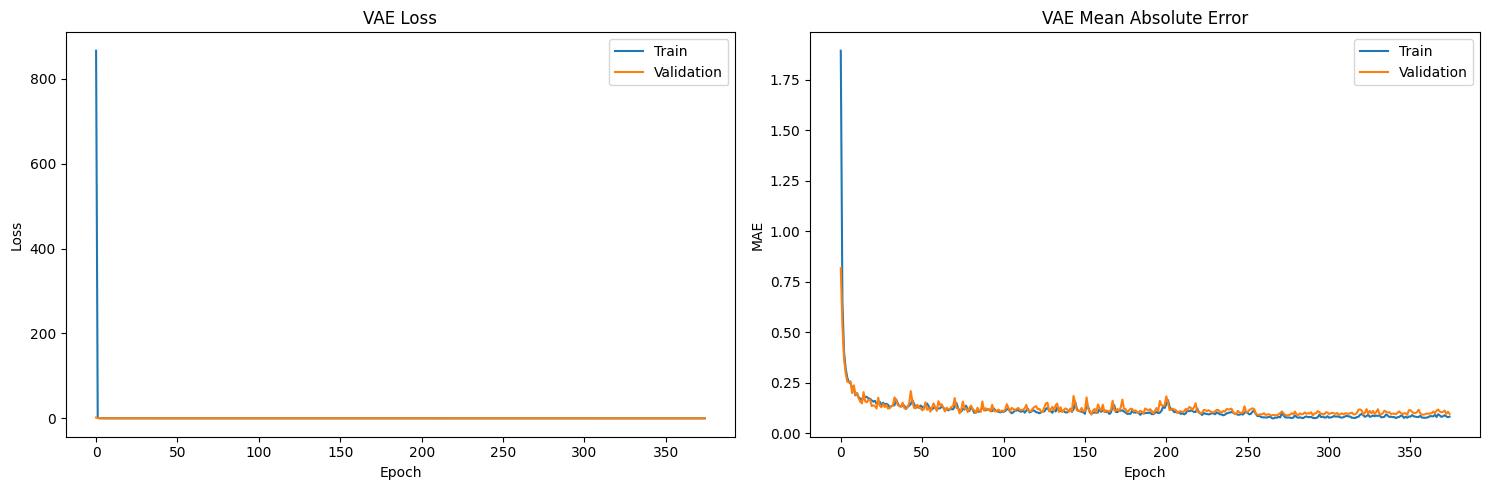

System saved to ../../output/models/vae_system_ss_0_10_features.pkl
Training completed in 190.48 seconds
Estimated time remaining: 11.52 minutes
--------------------------------------------------

Training system 29/36 (29/36 total)
--------------------------------------------------
Training vae model with system_ss_0 using 50_features
Selecting top 50 features using random_forest method...
Selected 96 features (46 from prefixes, 50 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 44.3454
Function value obtained: 0.1180
Current minimum: 0.1180
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 32.6411
Function value obtained: 0.0178
Current minimum: 0.0178
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random

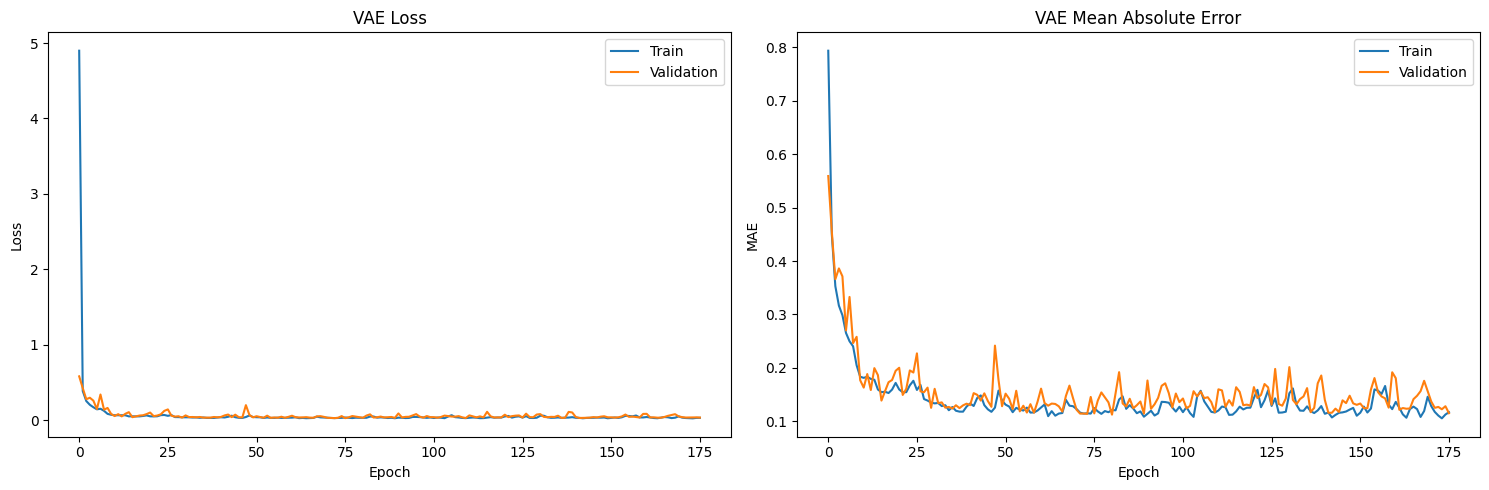

System saved to ../../output/models/vae_system_ss_0_50_features.pkl
Training completed in 258.44 seconds
Estimated time remaining: 10.77 minutes
--------------------------------------------------

Training system 30/36 (30/36 total)
--------------------------------------------------
Training vae model with system_ss_0 using 500_features
Selecting top 500 features using random_forest method...
Selected 401 features (46 from prefixes, 355 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.0541
Function value obtained: nan
Current minimum: nan
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 10.6573
Function value obtained: nan
Current minimum: nan
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
T

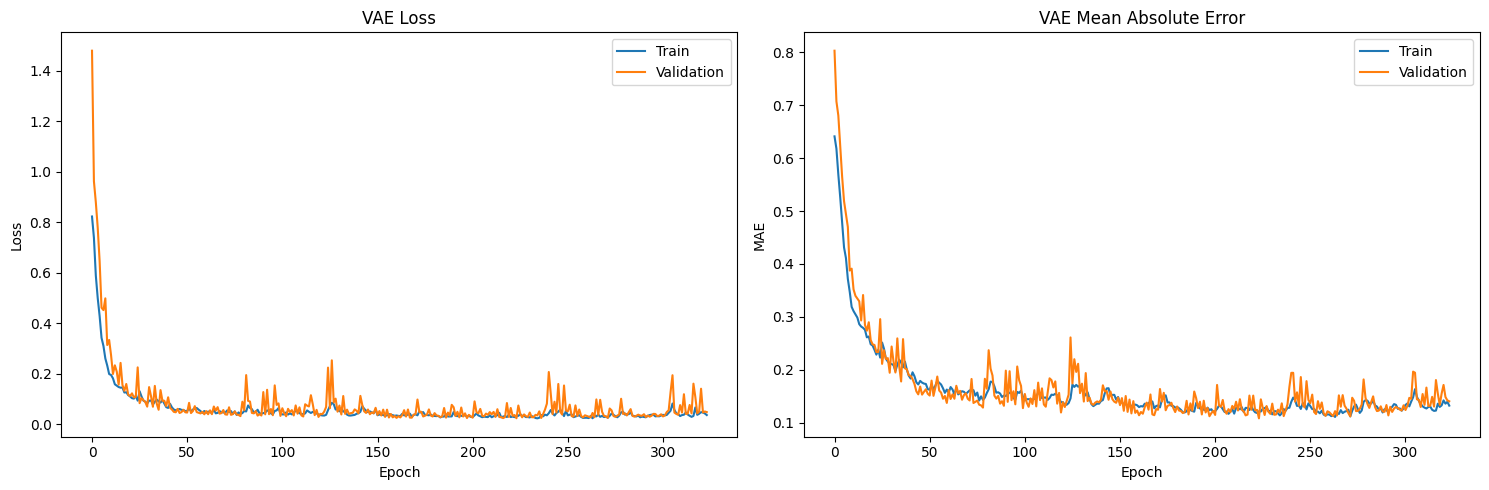

System saved to ../../output/models/vae_system_s_0_10_features.pkl
Training completed in 238.96 seconds
Estimated time remaining: 7.84 minutes
--------------------------------------------------

Training system 32/36 (32/36 total)
--------------------------------------------------
Training vae model with system_s_0 using 50_features
Selecting top 50 features using random_forest method...
Selected 71 features (21 from prefixes, 50 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.0934
Function value obtained: 1.4409
Current minimum: 1.4409
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 18.5602
Function value obtained: 1.4448
Current minimum: 1.4409
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random poi

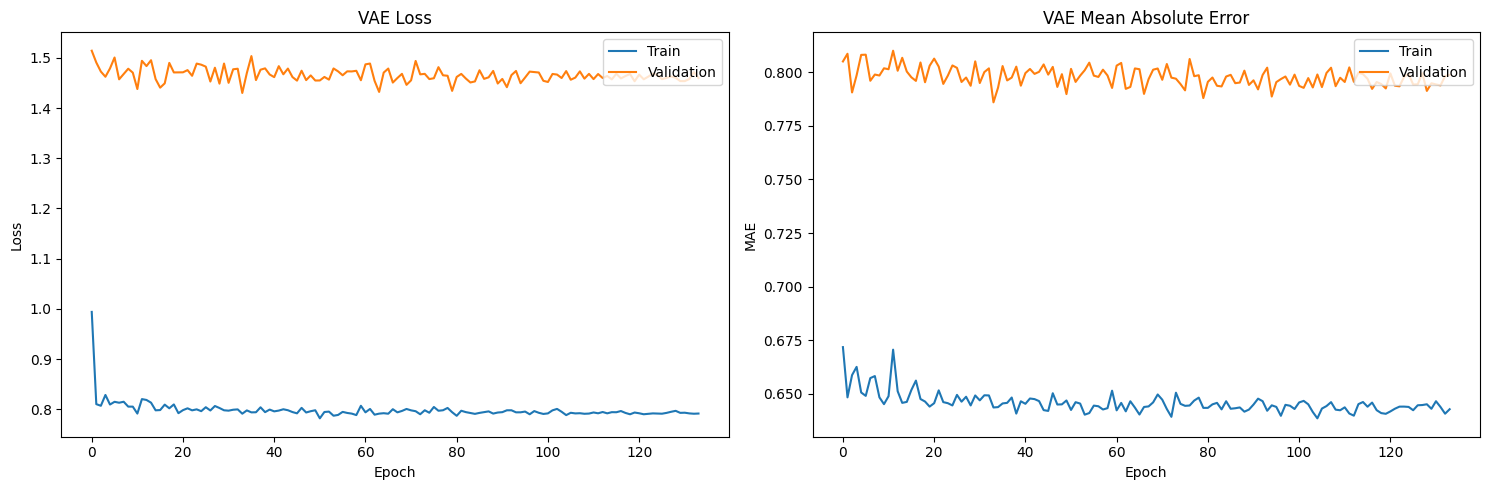

System saved to ../../output/models/vae_system_s_0_50_features.pkl
Training completed in 143.11 seconds
Estimated time remaining: 6.37 minutes
--------------------------------------------------

Training system 33/36 (33/36 total)
--------------------------------------------------
Training vae model with system_s_0 using 500_features
Selecting top 500 features using random_forest method...
Selected 521 features (21 from prefixes, 500 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.3866
Function value obtained: nan
Current minimum: nan
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 10.1501
Function value obtained: nan
Current minimum: nan
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time

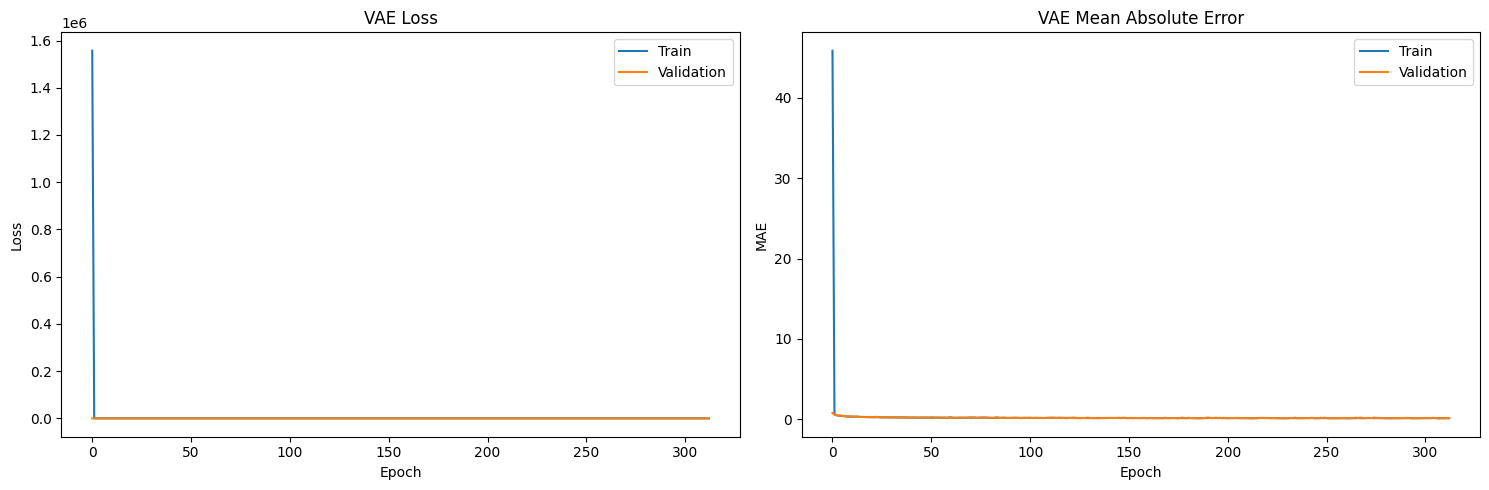

System saved to ../../output/models/vae_system_0_10_features.pkl
Training completed in 207.91 seconds
Estimated time remaining: 3.20 minutes
--------------------------------------------------

Training system 35/36 (35/36 total)
--------------------------------------------------
Training vae model with system_0 using 50_features
Selecting top 50 features using random_forest method...
Selected 54 features (4 from prefixes, 50 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.9866
Function value obtained: 1.4584
Current minimum: 1.4584
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 10.5313
Function value obtained: 1.4118
Current minimum: 1.4118
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
T

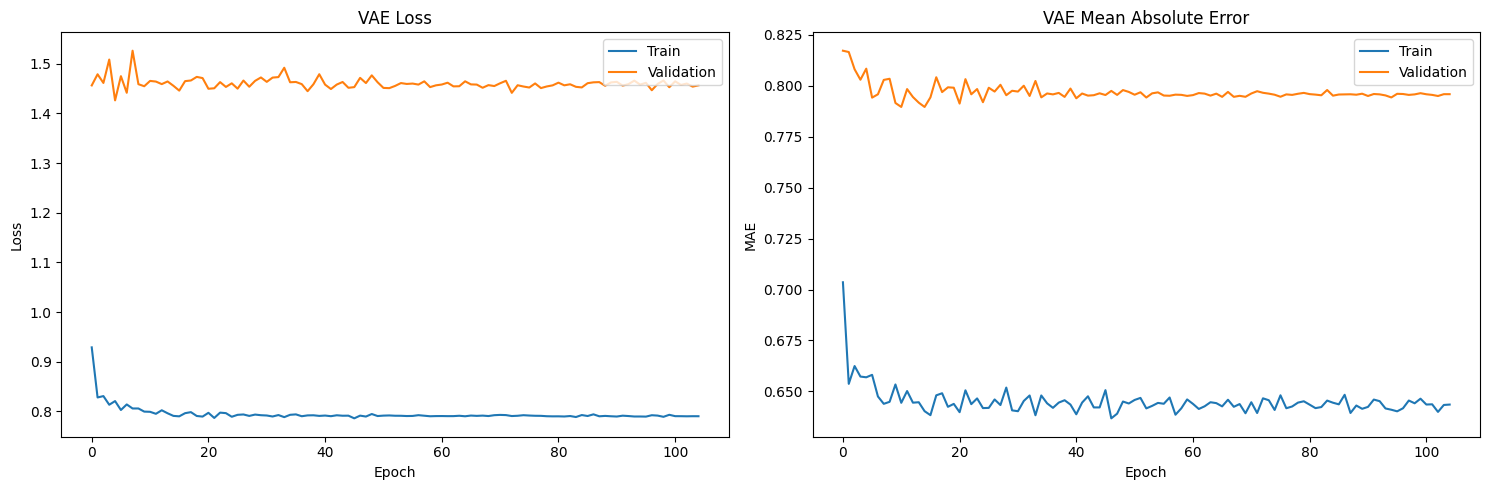

System saved to ../../output/models/vae_system_0_50_features.pkl
Training completed in 120.20 seconds
Estimated time remaining: 1.61 minutes
--------------------------------------------------

Training system 36/36 (36/36 total)
--------------------------------------------------
Training vae model with system_0 using 500_features
Selecting top 500 features using random_forest method...
Selected 504 features (4 from prefixes, 500 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.8259
Function value obtained: nan
Current minimum: nan
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.9699
Function value obtained: nan
Current minimum: nan
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken

['vae_system_sst_1_10_features.pkl',
 'vae_system_sst_1_50_features.pkl',
 'vae_system_sst_2_10_features.pkl',
 'vae_system_sst_2_50_features.pkl',
 'vae_system_ss_1_10_features.pkl',
 'vae_system_ss_1_50_features.pkl',
 'vae_system_s_1_10_features.pkl',
 'vae_system_s_1_50_features.pkl',
 'vae_system_s_2_50_features.pkl',
 'vae_system_1_10_features.pkl',
 'vae_system_1_50_features.pkl',
 'vae_system_1_50_features.pkl',
 'vae_system_sst_0_10_features.pkl',
 'vae_system_sst_0_50_features.pkl',
 'vae_system_ss_0_10_features.pkl',
 'vae_system_ss_0_50_features.pkl',
 'vae_system_s_0_10_features.pkl',
 'vae_system_s_0_50_features.pkl',
 'vae_system_0_10_features.pkl',
 'vae_system_0_50_features.pkl']

In [15]:
run_all_systems(systemPermutations, start_idx=0, max_systems=None, raw_data_path='curve_fit_results_x_is_7.csv',
                   base_save_path="../../output/models/") 

next steps
- repeat for additional data points is zero 
    - NB: the assumption being made is that the user will always have a way to predict single solvent system, this could be via the Van't Hoff Equation or creaitng a similar framework like his one for the Van't Hoff Equation, future work could focus on combining two approaches, one for single solvent predict, and then go into binary solubility prediction or 1 single model that does the JA VH equation is plausible aswell.
- take the best performing models and train them (ideally without needed to use the hyperparameter stuff - train to see if i can pull that out of the current models) use a test set where the api is not present in the group at all.

# VAE

In [16]:
from vae_model import VAEWithFeatureSelection

# Create and setup the system with VAE model
system = SystemDesign(
    system_columns=[],
    raw_data_path='curve_fit_results_x_is_7.csv',
    extra_fitted_points=1,
    target_columns=['J0', 'J1', 'J2']
)

# Train the VAE model
system.train_model(
    model_class=VAEWithFeatureSelection,
    feature_selection_method='random_forest',
    n_features=50,
    keep_prefixes=['solvent_1_pure', 'solvent_2_pure', 'system', 'solubility_', 'temperature'],
    epochs=1000,
    batch_size=32,
    verbose=1,
    optimize_hyperparams=True,
    n_calls=150,
    latent_dim=16,
    kl_weight=0.001
)

system.save("../../output/models/vae_model_sst_r.pkl")

Selecting top 50 features using random_forest method...
Selected 86 features (36 from prefixes, 50 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.5682
Function value obtained: 1.4479
Current minimum: 1.4479
Iteration No: 2 started. Evaluating function at random point.


KeyboardInterrupt: 

In [101]:
system_load = system

In [303]:
system_load = SystemDesign.load("../../output/models/vae_system_s_2_50_features.pkl")

System loaded from ../../output/models/vae_system_s_2_50_features.pkl


In [304]:
x,y = system_load.get_data_split_df()
y_pred = system_load.predict_model(x)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [305]:
from data_module import DataProcessor
otherDataProcessor,_ = DataProcessor.CreateDataProcessor("curve_fit_results_x_is_3.csv")
results_df = system_load.dataprocess.raw_data[['group_index','temperature','solvent_1_pure','solvent_2_pure','J0','J1','J2']].merge(
    y_pred,
    left_index=True,
    right_index=True,
    suffixes=('','_pred')
).merge(
    otherDataProcessor.raw_data[['group_index','J0','J1','J2']],
    on='group_index',
    suffixes=('', '_JA5')
).drop_duplicates()

In [306]:
import matplotlib.pyplot as plt
from equations import JouybanAcreeModel
import numpy as np
from groups import ja_groups

# Set up initial configurations for plots
plt.rcParams.update({
    'font.size': 12,          # Default font size
    'axes.labelsize': 14,     # Axis labels
    'axes.titlesize': 16,     # Subplot titles
    'xtick.labelsize': 12,    # X-axis tick labels
    'ytick.labelsize': 12,    # Y-axis tick labels
    'legend.fontsize': 12,    # Legend text
    'figure.titlesize': 18    # Figure title
})

In [307]:
n = -1

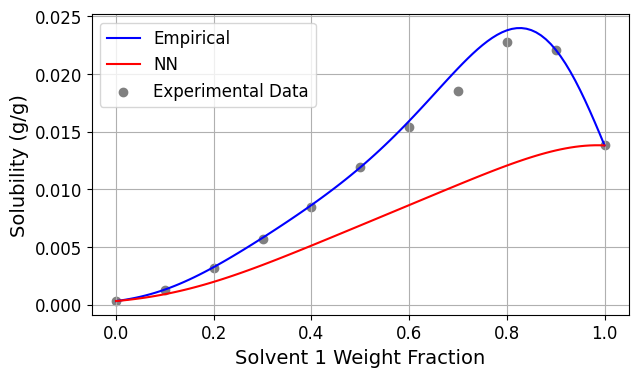

In [348]:
n +=1 
group_index = int(results_df.iloc[n]['group_index'])
group = ja_groups[group_index]



ja_model = JouybanAcreeModel()  
x_values = np.linspace(0, 1, 101)

JA_fit_real = ja_model.predict(
    x_values, 
    results_df['solvent_1_pure'].iloc[n],
    results_df['solvent_2_pure'].iloc[n], 
    results_df['temperature'].iloc[n],
    results_df['J0_JA5'].iloc[n],
    results_df['J1_JA5'].iloc[n],
    results_df['J2_JA5'].iloc[n],
)

JA_fit_NN = ja_model.predict(
    x_values, 
    results_df['solvent_1_pure'].iloc[n],
    results_df['solvent_2_pure'].iloc[n], 
    results_df['temperature'].iloc[n],
    results_df['J0_pred'].iloc[n],
    results_df['J1_pred'].iloc[n],
    results_df['J2_pred'].iloc[n],
)

# Plot the JA model
plt.figure(figsize=(16*1.3/3, 9*1.3/3))
plt.plot(x_values, JA_fit_real, label='Empirical', color='blue')
plt.plot(x_values, JA_fit_NN, label='NN', color='red')


# Add the experimental data points to the plot
plt.scatter(group['solvent_1_weight_fraction'], group['solubility_g_g'], color='gray', label='Experimental Data')
plt.xlabel('Solvent 1 Weight Fraction')
plt.ylabel('Solubility (g/g)')
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
from vae_model import VAEWithFeatureSelection

# Create and setup the system with VAE model
system = SystemDesign(
    system_columns=['solvent_1', 'solvent_2'],
    raw_data_path='curve_fit_results_x_is_7.csv',
    extra_fitted_points=1,
    target_columns=['J0', 'J1', 'J2']
)

# Train the VAE model
system.train_model(
    model_class=VAEWithFeatureSelection,
    feature_selection_method='random_forest',
    n_features=10,
    keep_prefixes=['solvent_1_pure', 'solvent_2_pure', 'system', 'solubility_', 'temperature'],
    epochs=1000,
    batch_size=32,
    verbose=1,
    optimize_hyperparams=True,
    n_calls=100,
    latent_dim=16,
    kl_weight=0.001
)

system.save("../../output/models/vae_model_ss_r.pkl")

Selecting top 10 features using random_forest method...
Selected 57 features (47 from prefixes, 10 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 11.6279
Function value obtained: 0.0733
Current minimum: 0.0733
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 15.1192
Function value obtained: 0.0172
Current minimum: 0.0172
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.1670
Function value obtained: 0.0264
Current minimum: 0.0172
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 10.4395
Function value obtained: 0.0194
Current minimum: 0.0172
Iteration No: 5 started. Evaluating function at random point

ValueError: Input y contains NaN.

In [192]:
from vae_model import VAEWithFeatureSelection

# Create and setup the system with VAE model
system = SystemDesign(
    system_columns=['solvent_1'],
    raw_data_path='curve_fit_results_x_is_7.csv',
    extra_fitted_points=1,
    target_columns=['J0', 'J1', 'J2']
)

# Train the VAE model
system.train_model(
    model_class=VAEWithFeatureSelection,
    feature_selection_method='random_forest',
    n_features=50,
    keep_prefixes=['solvent_1_pure', 'solvent_2_pure', 'system', 'solubility_', 'temperature'],
    epochs=10,
    batch_size=32,
    verbose=1,
    optimize_hyperparams=True,
    n_calls=100,
    latent_dim=16,
    kl_weight=0.001
)

system.save("../../output/models/vae_model_s_r.pkl")

Selecting top 50 features using random_forest method...
Selected 72 features (22 from prefixes, 50 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.5382
Function value obtained: 1.4456
Current minimum: 1.4456
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 10.1593
Function value obtained: 1.4339
Current minimum: 1.4339
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.8420
Function value obtained: 1.4515
Current minimum: 1.4339
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.2581
Function value obtained: 1.4412
Current minimum: 1.4339
Iteration No: 5 started. Evaluating function at random point.
I

In [ ]:
system = system.load("../../output/models/vae_model.pkl")

In [ ]:
from neural_network_model import NeuralNetworkWithFeatureSelection

# Create and setup the system
system = SystemDesign(
    system_columns=['solvent_1','solvent_2','temperature'],
    raw_data_path='curve_fit_results_x_is_7.csv',
    extra_fitted_points=1,
    target_columns=['J0','J1','J2']
)

# Train the model
system.train_model(
    model_class=NeuralNetworkWithFeatureSelection,
    feature_selection_method='random_forest',
    n_features=10,
    keep_prefixes=['solvent_1_pure','solvent_2_pure','system','solubility_','temperature'],
    epochs=1000, 
    batch_size=32, 
    verbose=1,
    optimize_hyperparams=True,
    n_calls=200
)

# Evaluate the model
system.evaluate_model()

# Get predictions and metrics
predictions, actuals, mae = system.get_predictions_and_metrics()

system.save("../../output/models/nn_model_sst_r.pkl")

In [ ]:
from neural_network_model import NeuralNetworkWithFeatureSelection

# Create and setup the system
system = SystemDesign(
    system_columns=['solvent_1','solvent_2'],
    raw_data_path='curve_fit_results_x_is_7.csv',
    extra_fitted_points=1,
    target_columns=['J0','J1','J2']
)

# Train the model
system.train_model(
    model_class=NeuralNetworkWithFeatureSelection,
    feature_selection_method='random_forest',
    n_features=10,
    keep_prefixes=['solvent_1_pure','solvent_2_pure','system','solubility_','temperature'],
    epochs=1000, 
    batch_size=32, 
    verbose=1,
    optimize_hyperparams=True,
    n_calls=200
)

# Evaluate the model
system.evaluate_model()

# Get predictions and metrics
predictions, actuals, mae = system.get_predictions_and_metrics()

system.save("../../output/models/nn_model_ss_r.pkl")

In [ ]:
from neural_network_model import NeuralNetworkWithFeatureSelection

# Create and setup the system
system = SystemDesign(
    system_columns=['solvent_1'],
    raw_data_path='curve_fit_results_x_is_7.csv',
    extra_fitted_points=1,
    target_columns=['J0','J1','J2']
)

# Train the model
system.train_model(
    model_class=NeuralNetworkWithFeatureSelection,
    feature_selection_method='random_forest',
    n_features=10,
    keep_prefixes=['solvent_1_pure','solvent_2_pure','system','solubility_','temperature'],
    epochs=1000, 
    batch_size=32, 
    verbose=1,
    optimize_hyperparams=True,
    n_calls=200
)

# Evaluate the model
system.evaluate_model()

# Get predictions and metrics
predictions, actuals, mae = system.get_predictions_and_metrics()

system.save("../../output/models/nn_model_s_r.pkl")

In [ ]:
system.save("../../output/models/nn_model.pkl")

In [ ]:
system.load("../../output/models/nn_model.pkl")

In [12]:
from mainv3 import SystemDesign

In [13]:
from xgb_model import XGBoostWithFeatureSelection

# Create and setup the system with XGBoost model
system = SystemDesign(
    system_columns=['solvent_1', 'solvent_2', 'temperature'],
    raw_data_path='curve_fit_results_x_is_7.csv',
    extra_fitted_points=1,
    target_columns=['J0', 'J1', 'J2']
)

# Train the XGBoost model
system.train_model(
    model_class=XGBoostWithFeatureSelection,
    feature_selection_method='random_forest',
    n_features=10,
    keep_prefixes=['solvent_1_pure', 'solvent_2_pure', 'system', 'solubility_', 'temperature'],
    verbose=1,
    optimize_hyperparams=True,
    n_calls=150,
    n_estimators=100,
    max_depth=6
)

# Evaluate the model
system.evaluate_model()

# Get predictions and metrics
predictions, actuals, mae = system.get_predictions_and_metrics()

# Plot feature importance
system.model.plot_feature_importance(top_n=15)

system.save("../../output/models/XGB_model_sst_r.pkl")



Selecting top 10 features using random_forest method...
Selected 389 features (379 from prefixes, 10 from selection)
Optimizing hyperparameters...
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3967
Function value obtained: 0.2296
Current minimum: 0.2296
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.6663
Function value obtained: 0.0856
Current minimum: 0.0856
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4427
Function value obtained: 0.2567
Current minimum: 0.0856
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.6483
Function value obtained: 0.3575
Current minimum: 0.0856
Iteration No: 5 started. Evaluat

KeyboardInterrupt: 

In [ ]:
system.save("../../output/models/XGB_model.pkl")

In [ ]:
system.load("../../output/models/XGB_model.pkl")